In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import \
        HyperparameterSensitivityLinearApproximation

from structure_vb_lib import structure_model_lib, posterior_quantities_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx
from structure_vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import structure_vb_lib.structure_optimization_lib as s_optim_lib

import re
import copy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename='huang2011_fit'
# out_folder='../fits/hgdp_fits/'

data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'

In [7]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'

# Load data

In [8]:
print(data_file)

../data/huang2011_sub_nobs25_nloci75.npz


In [9]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [10]:
g_obs.shape

(25, 75, 3)

# Load initial fit

In [11]:
print(init_fit_file)

../fits/tmp/huang2011_fit_sub_alpha6.0.npz


In [12]:
vb_init_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, init_fit_meta_data = \
            structure_model_lib.load_structure_fit(init_fit_file)

In [13]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

# Define vb sensitivity 

We need the hessian solver ... 

In [14]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                vb_params_paragami,
                                                prior_params_dict, 
                                                gh_loc, gh_weights, 
                                                jit_functions = False)

In [15]:
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_init_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)


In [16]:
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = stru_objective.f, 
                    opt_par_value = vb_init_free, 
                    hyper_par_value0 = np.array([0.]), 
                    obj_fun_hvp = stru_objective.hvp, 
                    # doens't matter for now; we just want the hessian solver
                    hyper_par_objective_fun = lambda x, y : 0., 
                    cg_precond = cg_precond, 
                    cg_tol = 1e-8,
                    cg_maxiter = None)

NOTE: using custom hvp
Compiling hessian solver ...
Hessian solver compile time: 97.9013sec

Compiling cross hessian...
Cross-hessian compile time: 0.0563588sec

LR sensitivity time: 0.0416932sec



# Influence functions

In [17]:
logit_v_grid = np.linspace(-6, 6, 200)

In [18]:
# class to get influence functions
influence_operator = influence_lib.InfluenceOperator(vb_init_free, 
                           vb_params_paragami, 
                           vb_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

In [19]:
def get_influence(g): 
    print('computing gradient ...')
    t0 = time.time()
    get_grad_g = jax.jacobian(g, argnums = 0)
    grad_g = get_grad_g(vb_init_free).block_until_ready()
    grad_g_time = time.time() - t0  
    print('Elapsed: {:.03f}sec'.format(grad_g_time))
    
    # get influence function
    print('inverting Hessian ...')
    t0 = time.time()
    
    influence_grid, grad_g_hess_inv = influence_operator.get_influence(logit_v_grid, 
                                                                       grad_g)
    hess_inv_time = time.time() - t0
    print('Elapsed: {:.03f}sec'.format(hess_inv_time))
          
    return influence_grid, grad_g_hess_inv, grad_g_time, hess_inv_time

### Influence function for expected number of obs per cluster

In [20]:
def get_e_num_ind(vb_free, k = 0): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    # select a 'k' before summing ... 
    # this is probably more efficient
    return e_ind_admix[:, k].sum()

In [21]:
e_num_ind_results = dict()
for k in range(4): 
    influence_grid, ghess = get_influence(lambda x : get_e_num_ind(x, k))[0:2]
    e_num_ind_results['influence_grid{}'.format(k)] = influence_grid
    e_num_ind_results['ghess{}'.format(k)] = ghess


computing gradient ...
Elapsed: 2.046sec
inverting Hessian ...
Elapsed: 3.097sec
computing gradient ...
Elapsed: 0.058sec
inverting Hessian ...
Elapsed: 1.202sec
computing gradient ...
Elapsed: 0.063sec
inverting Hessian ...
Elapsed: 1.110sec
computing gradient ...
Elapsed: 0.059sec
inverting Hessian ...
Elapsed: 1.158sec


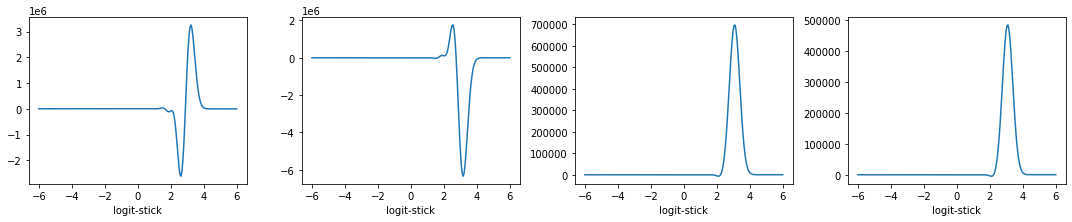

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (15, 3)) 
for k in range(4): 
    ax[k].plot(logit_v_grid, e_num_ind_results['influence_grid{}'.format(k)])
    
fig.tight_layout();

for a in ax: 
    a.set_xlabel('logit-stick')

### Define gaussian bumps

In [31]:
# def plot_gauss_bumps(ax): 
#     x = np.linspace(-6, 6, 1000)
    
#     for i in range(len(mu_vec)):
#         scale = 0.1
#         pdf = gauss_bump(x, mu_vec[i])
        
#         ax.plot(x,
#                 pdf, 
#                 color = 'grey', 
#                 alpha = 0.5)

In [32]:
# fig, ax = plt.subplots(1, 4, figsize = (15, 3)) 
# for k in range(4): 
    
#     # plot gaussian bumps
#     plot_gauss_bumps(ax[k])

#     # plot scaled influence function
#     infl_fun = e_num_ind_results['influence_grid{}'.format(k)]
#     scale = np.abs(infl_fun).max()
    
#     ax[k].plot(logit_v_grid, infl_fun / scale)
    
    
# fig.tight_layout();

# for a in ax: 
#     a.set_xlabel('logit-stick')

### Influence on expected number of clusters

In [33]:
def get_e_num_pred_clusters_from_vb_free(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.\
            get_e_num_pred_clusters(vb_params_dict,
                                    gh_loc,
                                    gh_weights, 
                                    n_samples = 1000,
                                    threshold = 0, 
                                    prng_key = jax.random.PRNGKey(3453), 
                                    return_samples = False)

In [28]:
influence_grid_num_clust, ghess_num_clust = get_influence(get_e_num_pred_clusters_from_vb_free)[0:2]

computing gradient ...
Elapsed: 6.065sec
inverting Hessian ...
Elapsed: 1.140sec


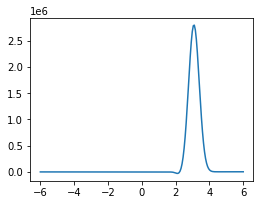

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3)) 

# actual infuence function
ax.plot(logit_v_grid, influence_grid_num_clust)

In [35]:
# fig, ax = plt.subplots(1, 2, figsize = (8, 3)) 

# # actual infuence function
# ax[0].plot(logit_v_grid, influence_grid_num_clust)

# # scaled influence function
# plot_gauss_bumps(ax[1])
# infl_fun = e_num_ind_results['influence_grid{}'.format(k)]
# ax[1].plot(logit_v_grid, 
#           influence_grid_num_clust / np.abs(influence_grid_num_clust).max())


# Plot results

In [94]:
mu_vec = np.linspace(1, 5, 6)

In [95]:
def gauss_bump(x, mu): 
    scale = 0.2
    pdf = sp.stats.norm.pdf(x, 
                            loc = mu, 
                            scale = scale)
    # normalize so max is 1
    pdf *= np.sqrt(2 * np.pi * scale ** 2)
    
    return pdf

### load refit results

In [96]:
def _load_refit_results_for_mu(g, mu_indx): 
    match_crit = out_filename + '_gaussbump' + '_mu{}_eps'.format(mu_indx) + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]

    epsilon_vec = onp.zeros(len(refit_files))
    refit_g_vec = onp.zeros(len(refit_files))

    for i in range(len(refit_files)): 
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])

        # get posterior quantity
        refit_g_vec[i] = g(vb_params_paragami.flatten(vb_params_dict, 
                                                      free = True))

        # get epsilon 
        epsilon_vec[i] = meta_data['epsilon']

        assert meta_data['mu'] == mu_vec[mu_indx]

    # permute epsilon 
    _indx = onp.argsort(epsilon_vec)
    epsilon_vec = epsilon_vec[_indx]
    refit_g_vec = refit_g_vec[_indx]
    
    return refit_g_vec, epsilon_vec

In [97]:
def load_refit_results(g): 
        
    for j in range(6): 
        # load results from particular mu
        refit_g_vec, epsilon_vec = \
            _load_refit_results_for_mu(g, j)
        
        if j == 0: 
            refit_g_array = onp.zeros((len(mu_vec), len(epsilon_vec)))
            _epsilon_vec = epsilon_vec
        refit_g_array[j] = refit_g_vec
        
        assert np.all(_epsilon_vec == epsilon_vec)
        
    return refit_g_array, epsilon_vec
        

### compute cross-hessians

In [98]:
cross_hess_list = []

for mu in mu_vec: 
    # compute linear response stuff
    f_obj = func_sens_lib.FunctionalPerturbationObjective(lambda x : gauss_bump(x, mu), 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'ind_admix_params')

    vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)
    
    cross_hess_list.append(vb_sens.cross_hess.squeeze())

Compiling cross hessian...
Cross-hessian compile time: 0.405892sec

LR sensitivity time: 0.702284sec

Compiling cross hessian...
Cross-hessian compile time: 0.307792sec

LR sensitivity time: 0.697222sec

Compiling cross hessian...
Cross-hessian compile time: 0.30709sec

LR sensitivity time: 0.666587sec

Compiling cross hessian...
Cross-hessian compile time: 0.306405sec

LR sensitivity time: 0.675059sec

Compiling cross hessian...
Cross-hessian compile time: 0.305985sec

LR sensitivity time: 0.653574sec

Compiling cross hessian...
Cross-hessian compile time: 0.308332sec

LR sensitivity time: 0.645633sec



In [102]:
def get_lr_results(g, ghess, epsilon_vec):
    lr_g_array = onp.zeros((len(mu_vec), len(epsilon_vec)))

    for i in range(len(mu_vec)): 

        # derivative of posterior quantity wrt hyper parameter
        dg_dhyper = np.dot(ghess, cross_hess_list[i])
        
        # get lr results
        lr_g_array[i, :] = g(vb_init_free) + dg_dhyper * epsilon_vec
        
    return lr_g_array

In [152]:
def plot_results(g, ghess, influence_grid): 
    
    refit_g_array, epsilon_vec = load_refit_results(g)
    
    # lr results
    lr_g_array = get_lr_results(g, 
                                ghess_num_clust, 
                                epsilon_vec)
    
    fig, ax = plt.subplots(2, len(mu_vec), figsize = (18, 6))
    
    x = np.linspace(-6, 6, 1000)
    
    infl_scale = np.abs(influence_grid).max()
    
    for i in range(len(mu_vec)): 
        # plot influence function
        ax[0, i].plot(logit_v_grid, influence_grid / infl_scale)
        ax[0, i].set_xlabel('logit stick')
        
        # overlay gaussian bump
        ax[0, i].plot(x, gauss_bump(x, mu = mu_vec[i]), color = 'grey')
        
        
        # plot refit results
        ax[1, i].plot(epsilon_vec,
                      refit_g_array[i, :] - refit_g_array[i, 0], 
                      '-o')

        # plot lr results
        ax[1, i].plot(epsilon_vec, 
                      lr_g_array[i, :] - lr_g_array[i, 0], 
                      '-o')
        ax[1, i].set_xlabel('epsilon')
        
        
    fig.tight_layout()
    
    return refit_g_array, lr_g_array, epsilon_vec

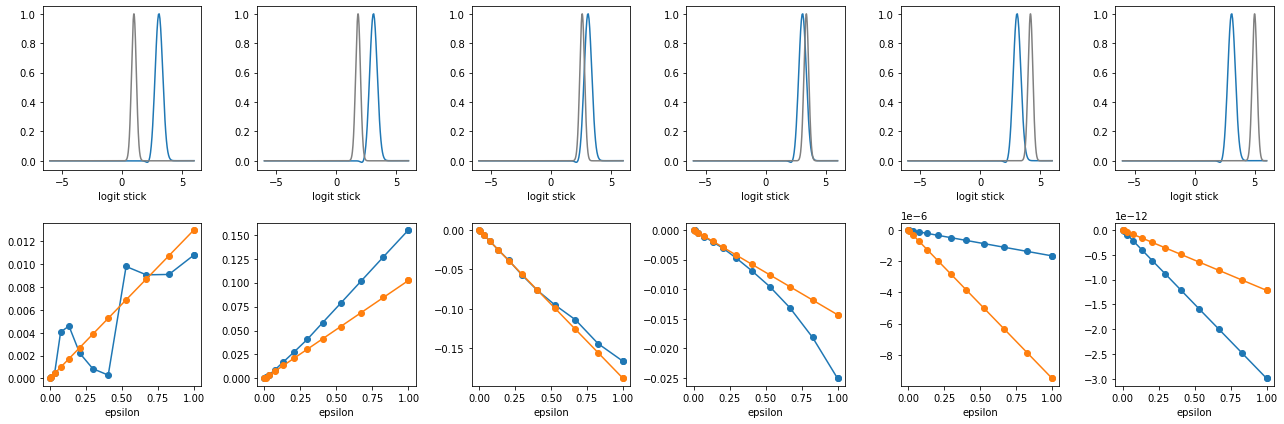

In [153]:
refit_g_array, lr_g_array, epsilon_vec = \
    plot_results(get_e_num_pred_clusters_from_vb_free,
                 ghess_num_clust, 
                 influence_grid_num_clust)

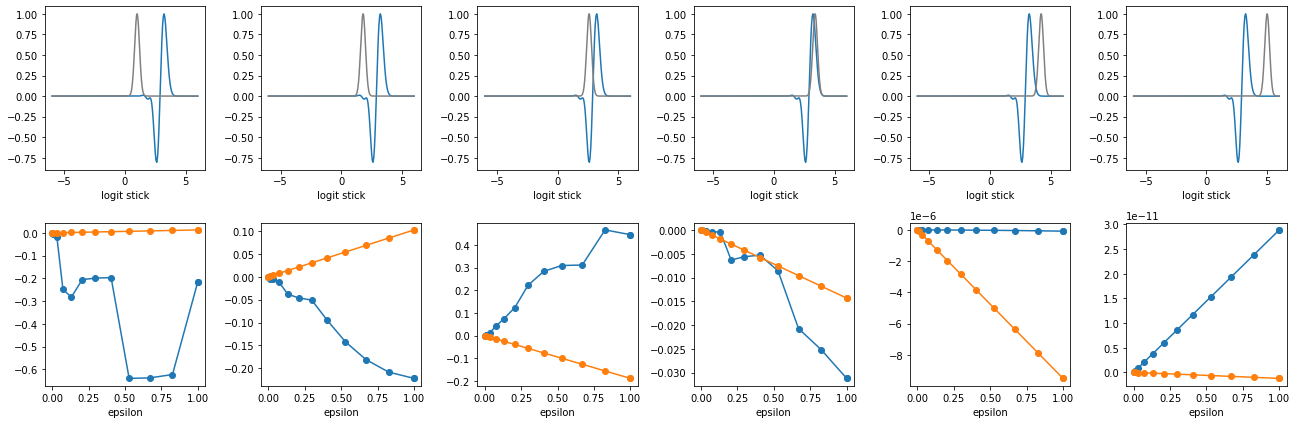

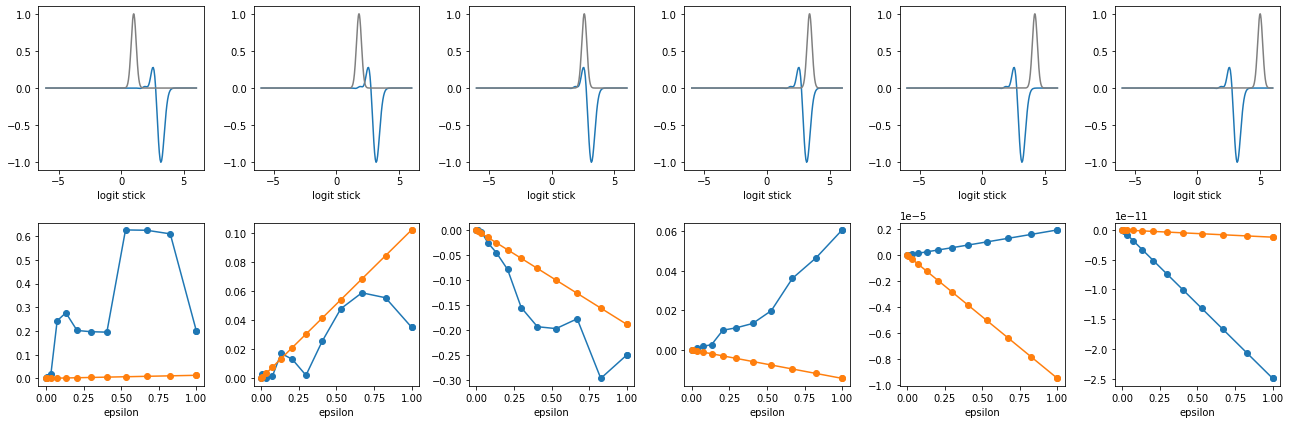

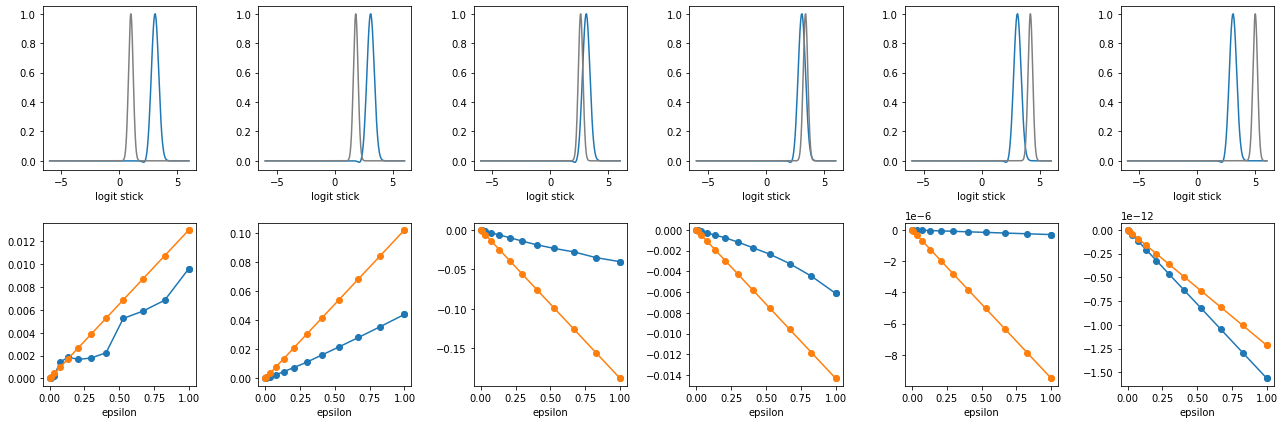

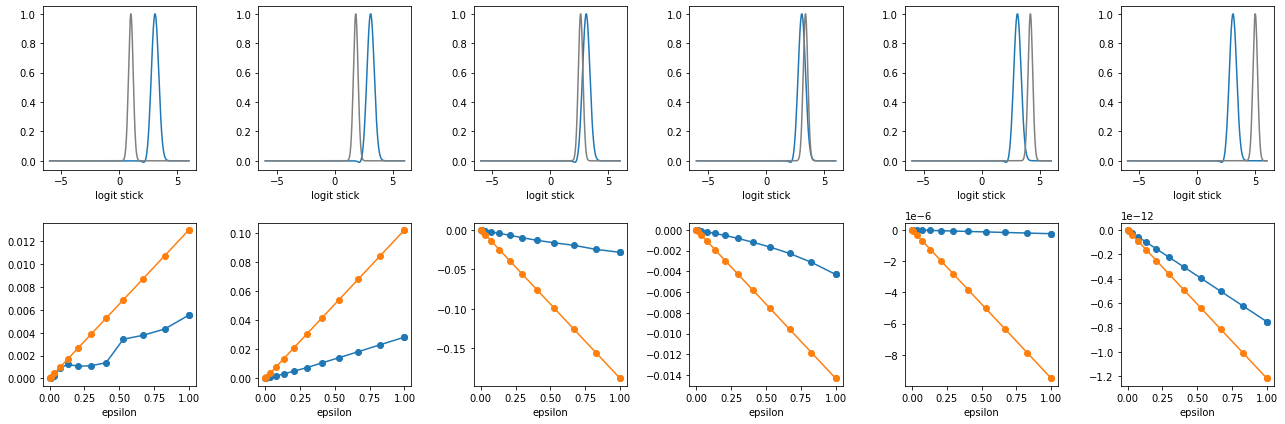

In [156]:
for k in range(4): 
    refit_g_array, lr_g_array, epsilon_vec = \
        plot_results(lambda x : get_e_num_ind(x, k), 
                     e_num_ind_results['ghess{}'.format(k)], 
                     e_num_ind_results['influence_grid{}'.format(k)])